In [19]:
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import csv

In [8]:
HEADERS = {
    "Content-Type": "application/json",
    "Accept": "application/json"
}

REQUEST_TIMEOUT = 30 # Timeout for each request in seconds

def send_post_request(url, payload, headers, timeout):
    """
    Sends a single HTTP POST request and measures its response time.

    Args:
        url (str): The target URL.
        payload (dict): The JSON payload for the request.
        headers (dict): The HTTP headers.
        timeout (int): Request timeout in seconds.

    Returns:
        tuple: (response_time_ms, status_code, data, error_message)
    """
    start_time = time.perf_counter()
    status_code = None

    try:
        response = requests.post(url, json=payload, headers=headers, timeout=timeout)
        end_time = time.perf_counter()
        response_time_ms = (end_time - start_time) * 1000
        status_code = response.status_code
        response.raise_for_status()
        data = response.json() if response.content else None

        # check if data is empty
        if not data:
            error_message = f"Empty data"
            print(f"Returned empty data: {data}")
            return None, None, None, error_message


        return response_time_ms, status_code, data, None

    except requests.exceptions.Timeout:
        end_time = time.perf_counter()
        response_time_ms = (end_time - start_time) * 1000
        error_message = "Request timed out"
        print(f"Warning: Request to {url} timed out after {response_time_ms:.2f} ms.")
        return response_time_ms, None,  None, error_message

    except requests.exceptions.ConnectionError as e:
        error_message = f"Connection error: {e}"
        print(f"Error: Could not connect to {url}. Is the server running? {e}")
        return None, None, None, error_message

    except requests.exceptions.RequestException as e:
        end_time = time.perf_counter()
        response_time_ms = (end_time - start_time) * 1000
        error_message = f"Request failed: {e}"
        print(f"Error: Request to {url} failed with: {e}")
        return response_time_ms, status_code, None, error_message

    except Exception as e:
        error_message = f"An unexpected error occurred: {e}"
        print(f"Critical Error: {e}")
        return None, None, None, error_message

In [9]:
def exec_test_case(endpoint, request, is_valid_answer):
    payload = { "request": request }


    time_ms, status, data, error = send_post_request(endpoint, payload, HEADERS, REQUEST_TIMEOUT)

    if status is not None and 200 <= status < 300:
        print("Server responded in " + str(time_ms) + " ms with data " + str(data))
        if is_valid_answer(data):
            print("Valid answer")
            return "PASSED", time_ms
        else:
            print("Invalid Answer")
            return "FAILED", time_ms

    print("Server responded with error: " + str(error))
    return "ERROR", None

def exec_test(endpoint, request, is_valid_answer, number_of_requests, number_of_warmup_requests):
    results = []
    passed_requests_count = 0
    failed_requests_count = 0
    error_requests_count = 0

    initial_delay = 20
    max_delay = 100
    step_delay = 1

    print(f"Starting warmup phase ({number_of_warmup_requests} requests)...")
    for _ in range(number_of_warmup_requests):
        exec_test_case(endpoint, request, is_valid_answer)
    print("Warmup phase complete.\n")

    print(f"Starting test phase ({number_of_requests} successful requests targeted)...")
    requests_made = 0
    current_delay = initial_delay


    while requests_made < number_of_requests:
        print(f"------------------------- Request {requests_made + 1}/{number_of_requests} ------------------------- ")

        try:
            result_status, time_ms = exec_test_case(endpoint, request, is_valid_answer)

            if result_status == "PASSED":
                passed_requests_count += 1
                results.append({"time": time_ms, "result": "PASSED"})
                requests_made += 1
                current_delay = initial_delay
                time.sleep(step_delay)
            elif result_status == "FAILED":
                failed_requests_count += 1
                results.append({"time": time_ms, "result": "FAILED"})
                requests_made += 1
                current_delay = initial_delay
                time.sleep(step_delay)
            else:
                error_requests_count += 1
                print(f"ERROR_REQUEST encountered. Retrying after {current_delay:.2f} seconds...")
                time.sleep(current_delay)
                current_delay = min(current_delay * 2, max_delay) # Exponential backoff

        except Exception as e:
            error_requests_count += 1
            print(f"An unexpected error occurred: {e}. Retrying after {current_delay:.2f} seconds...")
            time.sleep(current_delay)
            current_delay = min(current_delay * 2, max_delay) # Exponential backoff

    print("********************************************")
    print("\nTest Summary:")
    print(f"Successful Requests Targeted: {number_of_requests}")
    print(f"Actual Requests Made (PASSED/FAILED): {passed_requests_count + failed_requests_count}")
    print(f"  PASSED Responses : {passed_requests_count}")
    print(f"  FAILED Responses : {failed_requests_count}")
    print(f"ERROR_REQUESTs (not counted in total): {error_requests_count}")


    # Average execution time
    execution_times = [r["time"] for r in results if r["time"] is not None]
    if execution_times:
        avg_time = sum(execution_times) / len(execution_times)
        print(f"Average Execution Time: {avg_time:.2f} ms")


    return results

In [17]:
def plot_performance_and_reliability(results):
    # Extract times and result labels
    times = np.array([entry["time"] for entry in results])
    labels = [entry["result"] for entry in results]

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Performance & Reliability Analysis", fontsize=16)

    # 1. Execution Time Line Plot
    axs[0, 0].plot(times, marker='o', linestyle='-', color='blue')
    axs[0, 0].set_title("Execution Time Over Runs")
    axs[0, 0].set_xlabel("Run Index")
    axs[0, 0].set_ylabel("Time (ms)")
    axs[0, 0].grid(True)

    # 2. Execution Time Boxplot
    axs[0, 1].boxplot(times, vert=True)
    axs[0, 1].set_title("Execution Time Boxplot")
    axs[0, 1].set_ylabel("Time (ms)")

    # 3. Execution Time Histogram
    axs[0, 2].hist(times, bins=20, color='skyblue', edgecolor='black')
    axs[0, 2].set_title("Execution Time Histogram")
    axs[0, 2].set_xlabel("Time (ms)")
    axs[0, 2].set_ylabel("Frequency")

    # 4. Cumulative Success Rate
    success_flags = np.array([1 if r == "PASSED" else 0 for r in labels])
    cum_success = np.cumsum(success_flags)
    cum_total = np.arange(1, len(results) + 1)
    cum_success_rate = cum_success / cum_total

    axs[1, 0].plot(cum_success_rate, color='green')
    axs[1, 0].set_title("Cumulative Success Rate")
    axs[1, 0].set_xlabel("Run Index")
    axs[1, 0].set_ylabel("Success Rate")
    axs[1, 0].set_ylim(0, 1.05)
    axs[1, 0].grid(True)

    # 5. Reliability Histogram (Count of each result)
    result_counts = Counter(labels)
    result_names, result_values = zip(*result_counts.items())
    axs[1, 1].bar(result_names, result_values, color='orange')
    axs[1, 1].set_title("Result Counts")
    axs[1, 1].set_ylabel("Occurrences")

    # 6. Hide empty subplot
    axs[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



def plot_flexible_test_comparison(test_data):
    """
    Compares the performance and reliability of an arbitrary number of test runs
    by plotting them on the same subplots with different labels.

    Args:
        test_data (list): A list of tuples, where each tuple contains:
                          (results, label)
                          - results (list): List of dictionaries for a test,
                                            each with "time" and "result" keys.
                          - label (str): Label for the test (e.g., "Test A").
    """

    if not test_data:
        print("No test data provided. Nothing to plot.")
        return

    # Prepare data for all tests
    times_all = []
    cum_success_rates_all = []
    result_counts_all = []
    all_labels = []
    all_possible_results = set()

    num_tests = len(test_data)
    # Fix 1: Use matplotlib.colormaps for colormaps
    colors = plt.colormaps['tab10'] # 'tab10' is good for up to 10 distinct colors

    for i, (results, label) in enumerate(test_data):
        if not results:
            print(f"No data for '{label}'. This test will not appear on the plots.")
            continue

        times = np.array([entry["time"] for entry in results])
        result_labels = [entry["result"] for entry in results]

        times_all.append(times)
        all_labels.append(label)

        # Calculate Cumulative Success Rate
        success_flags = np.array([1 if r == "PASSED" else 0 for r in result_labels])
        cum_success = np.cumsum(success_flags)
        cum_total = np.arange(1, len(results) + 1)
        cum_success_rate = cum_success / cum_total
        cum_success_rates_all.append(cum_success_rate)

        # Count results for reliability histogram
        counts = Counter(result_labels)
        result_counts_all.append(counts)
        all_possible_results.update(counts.keys())

    if not all_labels:
        print("All provided tests had no data. Nothing to plot.")
        return

    all_possible_results = sorted(list(all_possible_results))

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("Performance & Reliability Comparison Across Tests", fontsize=18)

    # --- Plotting on the same subplots ---

    # 1. Execution Time Line Plot
    ax_line = axs[0, 0]
    for i, times in enumerate(times_all):
        ax_line.plot(times, marker='o', linestyle='-', color=colors(i), label=all_labels[i])
    ax_line.set_title("Execution Time Over Runs")
    ax_line.set_xlabel("Run Index")
    ax_line.set_ylabel("Time (ms)")
    ax_line.grid(True)
    ax_line.legend()

    # 2. Execution Time Boxplot
    ax_boxplot = axs[0, 1]
    if times_all:
        # Fix 2: Use 'tick_labels' instead of 'labels'
        ax_boxplot.boxplot(times_all, vert=True, tick_labels=all_labels, patch_artist=True)
        for patch, color in zip(ax_boxplot.artists, [colors(i) for i in range(len(times_all))]):
            patch.set_facecolor(color)
    ax_boxplot.set_title("Execution Time Boxplot Comparison")
    ax_boxplot.set_ylabel("Time (ms)")
    ax_boxplot.tick_params(axis='x', rotation=45)
    ax_boxplot.grid(True, axis='y')


    # 3. Cumulative Success Rate
    ax_cum_success = axs[1, 0]
    for i, cum_rate in enumerate(cum_success_rates_all):
        ax_cum_success.plot(cum_rate, color=colors(i), label=all_labels[i])
    ax_cum_success.set_title("Cumulative Success Rate Comparison")
    ax_cum_success.set_xlabel("Run Index")
    ax_cum_success.set_ylabel("Success Rate")
    ax_cum_success.set_ylim(0, 1.05)
    ax_cum_success.grid(True)
    ax_cum_success.legend()

    # 4. Reliability Histogram (Grouped Bar Chart)
    ax_reliability = axs[1, 1]

    x = np.arange(len(all_possible_results))
    bar_width = 0.8 / len(all_labels) if len(all_labels) > 0 else 0.8

    for i, (counts, label) in enumerate(zip(result_counts_all, all_labels)):
        values = [counts.get(res, 0) for res in all_possible_results]
        offset = i * bar_width - (len(all_labels) - 1) * bar_width / 2
        ax_reliability.bar(x + offset, values, bar_width, label=label, color=colors(i), alpha=0.7)

    ax_reliability.set_title("Result Counts Comparison")
    ax_reliability.set_ylabel("Occurrences")
    ax_reliability.set_xticks(x)
    ax_reliability.set_xticklabels(all_possible_results)
    ax_reliability.tick_params(axis='x', rotation=45)
    ax_reliability.legend()
    ax_reliability.grid(True, axis='y')


    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()



    import csv

def save_results_to_csv(results, filename):
    """
    Saves the test results to a CSV file.

    Args:
        results (list): A list of dictionaries, where each dictionary
                        represents a single test result (e.g., {"time": 123, "result": "PASSED"}).
        filename (str): The name of the CSV file to save the results to.
    """
    if not results:
        print("No results to save.")
        return

    # Determine headers from the keys of the first result dictionary
    headers = results[0].keys()

    try:
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=headers)

            writer.writeheader() # Write the column headers
            writer.writerows(results) # Write all the result rows

        print(f"Results successfully saved to {filename}")
    except IOError as e:
        print(f"Error saving results to CSV: {e}")



In [11]:
COGNITIVE_WORKFLOW_URL = "http://localhost:3001/api/workflows/execute"
SIMPLE_LLM_URL = "http://localhost:3002/ai4ne/simple_llm"
FUNCTION_CALLING_LLM_URL = "http://localhost:3002/ai4ne/function_calling"

NUM_REQUESTS = 20
WARMUP_REQUESTS = 1
REQUEST_TIMEOUT = 30

REQUEST_TEXT = "I want to establish a 5G reliable connection to my friend"
#REQUEST_TEXT= "I want to establish a Real-time video straming 4k to Giovanni"
RIGHT_ANSWER = ["1", "3", "4"]

def is_valid_answer(answer):
    if not answer:
        return False

    path = answer.get("path") or answer.get("selectedPath")

    if path is None:
        return False

    if path != RIGHT_ANSWER:
        return False

    return True


Starting warmup phase (1 requests)...
Server responded in 5257.159417000366 ms with data {'path': ['1', '3', '4']}
Valid answer
Warmup phase complete.

Starting test phase (20 successful requests targeted)...
------------------------- Request 1/20 ------------------------- 
Server responded in 6843.007666000631 ms with data {'path': ['1', '3', '4']}
Valid answer
------------------------- Request 2/20 ------------------------- 
Server responded in 5150.3414580001845 ms with data {'path': ['1', '3', '4']}
Valid answer
------------------------- Request 3/20 ------------------------- 
Server responded in 4913.877375001903 ms with data {'path': ['1', '3', '4']}
Valid answer
------------------------- Request 4/20 ------------------------- 
Server responded in 7197.017209000478 ms with data {'path': ['1', '3', '4']}
Valid answer
------------------------- Request 5/20 ------------------------- 
Server responded in 6724.427959001332 ms with data {'path': ['1', '3', '4']}
Valid answer
----------

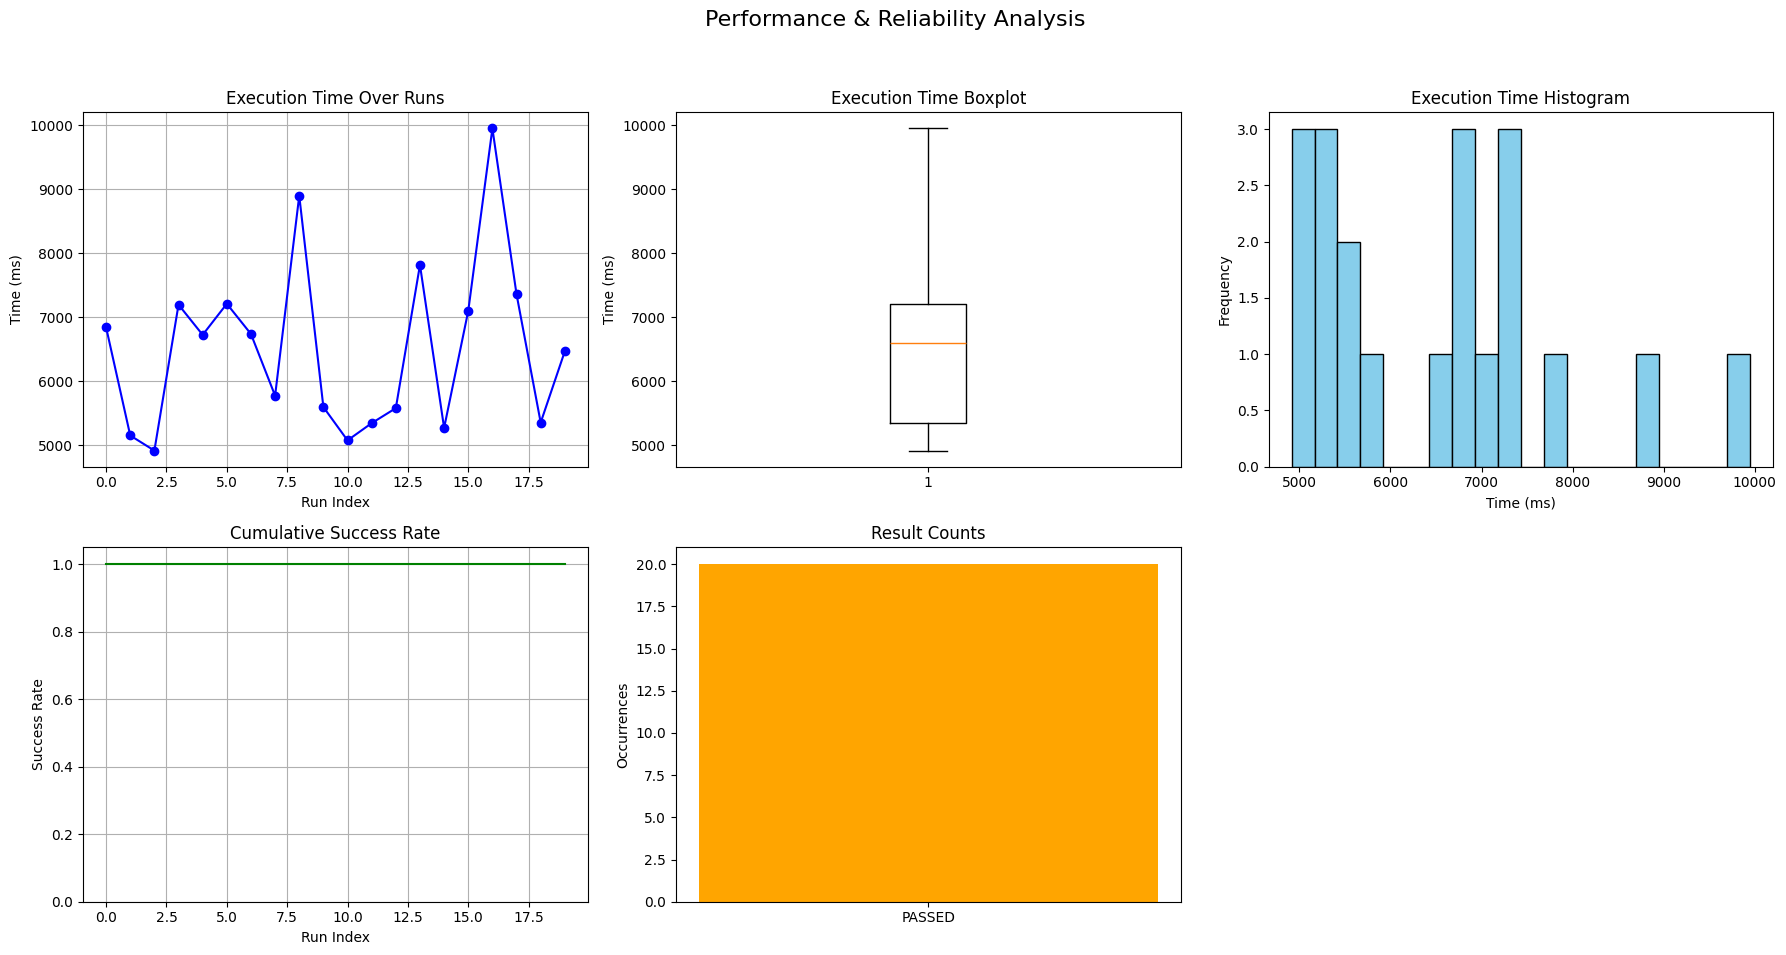

In [12]:
cognitive_workflow_results = exec_test(COGNITIVE_WORKFLOW_URL, REQUEST_TEXT, is_valid_answer, NUM_REQUESTS, WARMUP_REQUESTS)
plot_performance_and_reliability(cognitive_workflow_results)

Starting warmup phase (1 requests)...
Server responded in 3432.118291999359 ms with data {'selectedPath': ['1', '2', '4'], 'motivation': 'The selected path utilizes the Qualcomm Snapdragon X75 modem, which is specifically designed for 5G connections, ensuring high performance and reliability. It connects directly to the endpoint node, optimizing the route for minimal latency and maximum throughput.'}
Invalid Answer
Warmup phase complete.

Starting test phase (20 successful requests targeted)...
------------------------- Request 1/20 ------------------------- 
Server responded in 2100.24274999887 ms with data {'selectedPath': ['1', '3', '4'], 'motivation': 'The selected path is optimal for establishing a reliable 5G connection as it routes through the Qualcomm Snapdragon X75 modem, which is specifically designed for superior 5G performance. This modem provides advanced features such as AI-enhanced channel state feedback and support for advanced carrier aggregation, ensuring a robust and

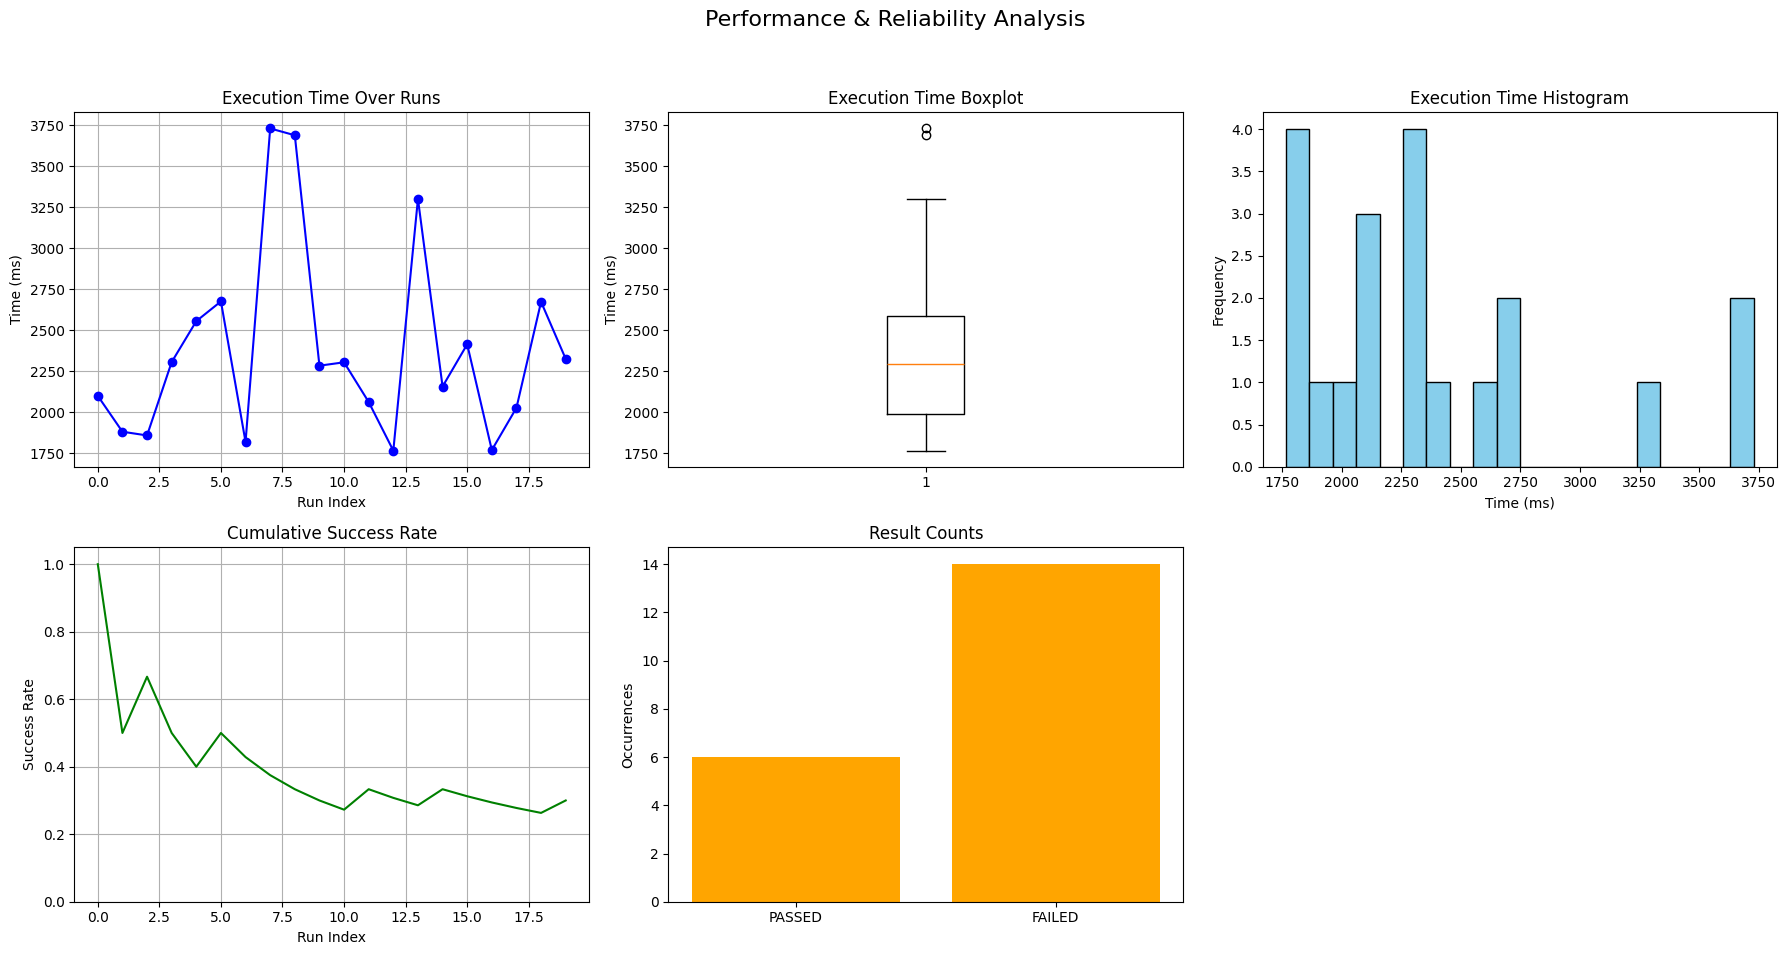

In [13]:
simple_llm_results = exec_test(SIMPLE_LLM_URL, REQUEST_TEXT, is_valid_answer, NUM_REQUESTS, WARMUP_REQUESTS)
plot_performance_and_reliability(simple_llm_results)

Starting warmup phase (1 requests)...
Server responded in 3867.733250001038 ms with data {'selectedPath': ['1', '3', '4'], 'motivation': 'The selected path optimally utilizes the Qualcomm Snapdragon X75 modem with advanced 5G capabilities, ensuring a reliable connection while offering high bandwidth and low latency. The network topology supports direct connections to this device for an efficient route.'}
Valid answer
Warmup phase complete.

Starting test phase (20 successful requests targeted)...
------------------------- Request 1/20 ------------------------- 
Server responded in 3070.139958002983 ms with data {'selectedPath': ['1', '2', '4'], 'motivation': 'The selected path includes devices that support 5G technology, ensuring a reliable connection with optimal performance and speed.'}
Invalid Answer
------------------------- Request 2/20 ------------------------- 
Server responded in 3500.169790997461 ms with data {'selectedPath': ['1', '2', '4'], 'motivation': 'The selected path u

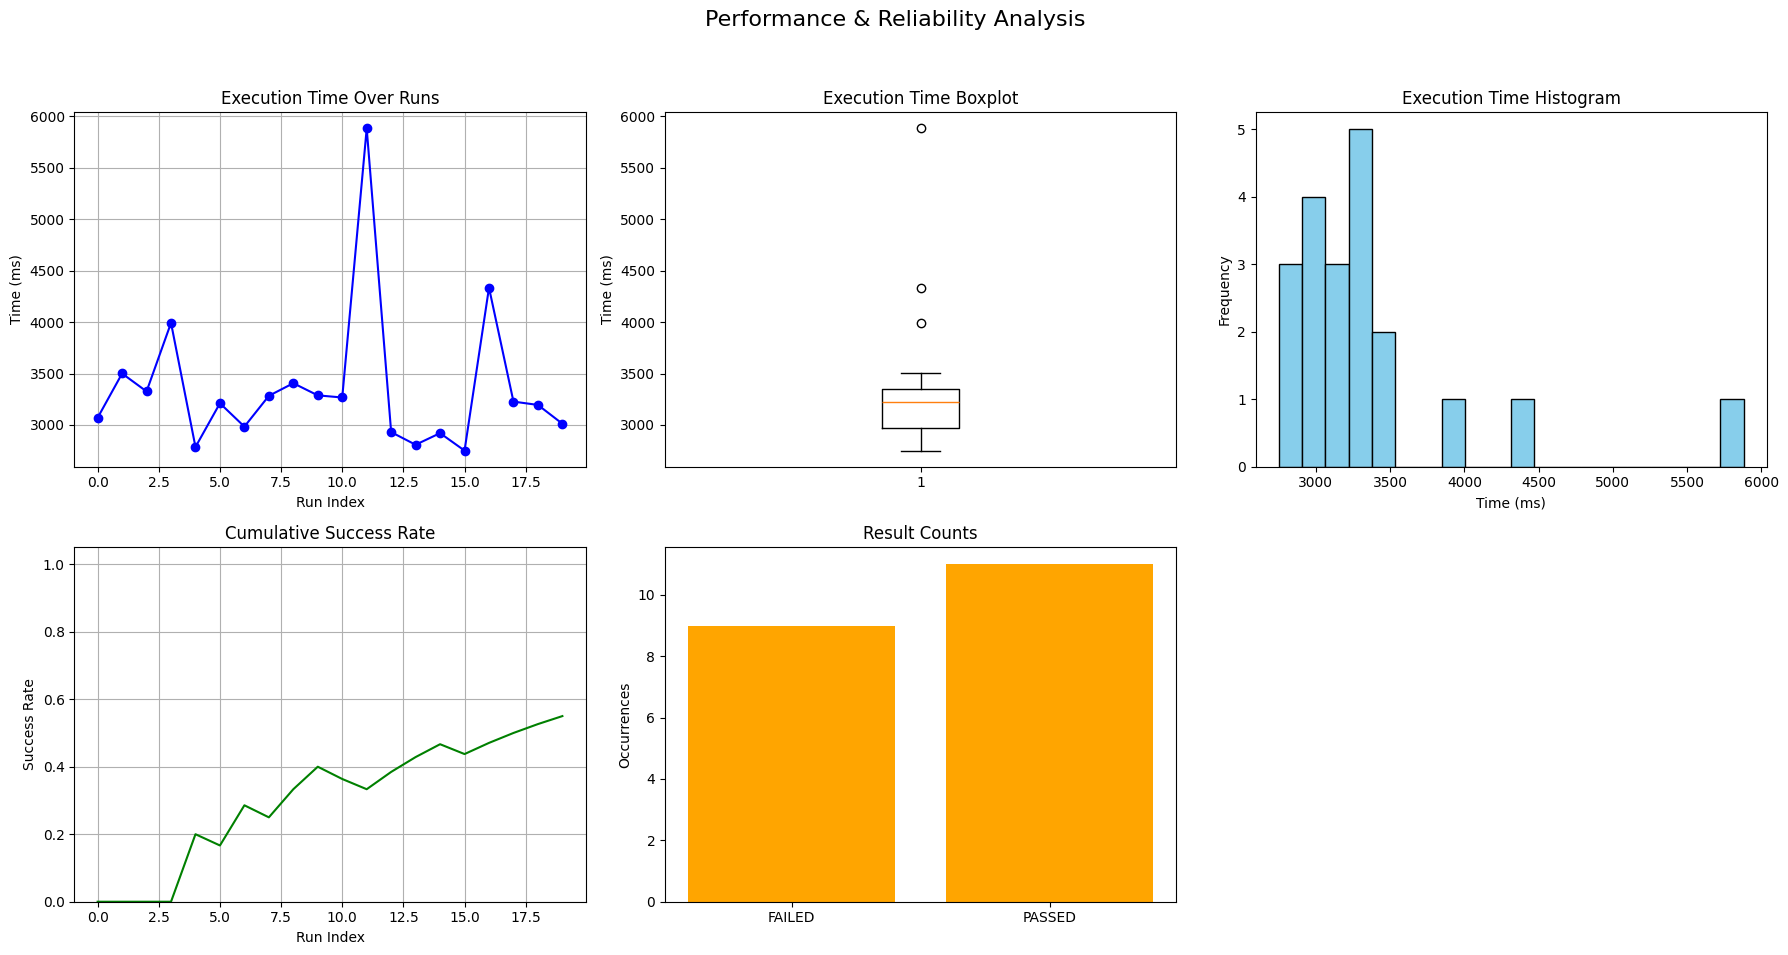

In [14]:
function_calling_llm_results = exec_test(FUNCTION_CALLING_LLM_URL, REQUEST_TEXT, is_valid_answer, NUM_REQUESTS, WARMUP_REQUESTS)
plot_performance_and_reliability(function_calling_llm_results)

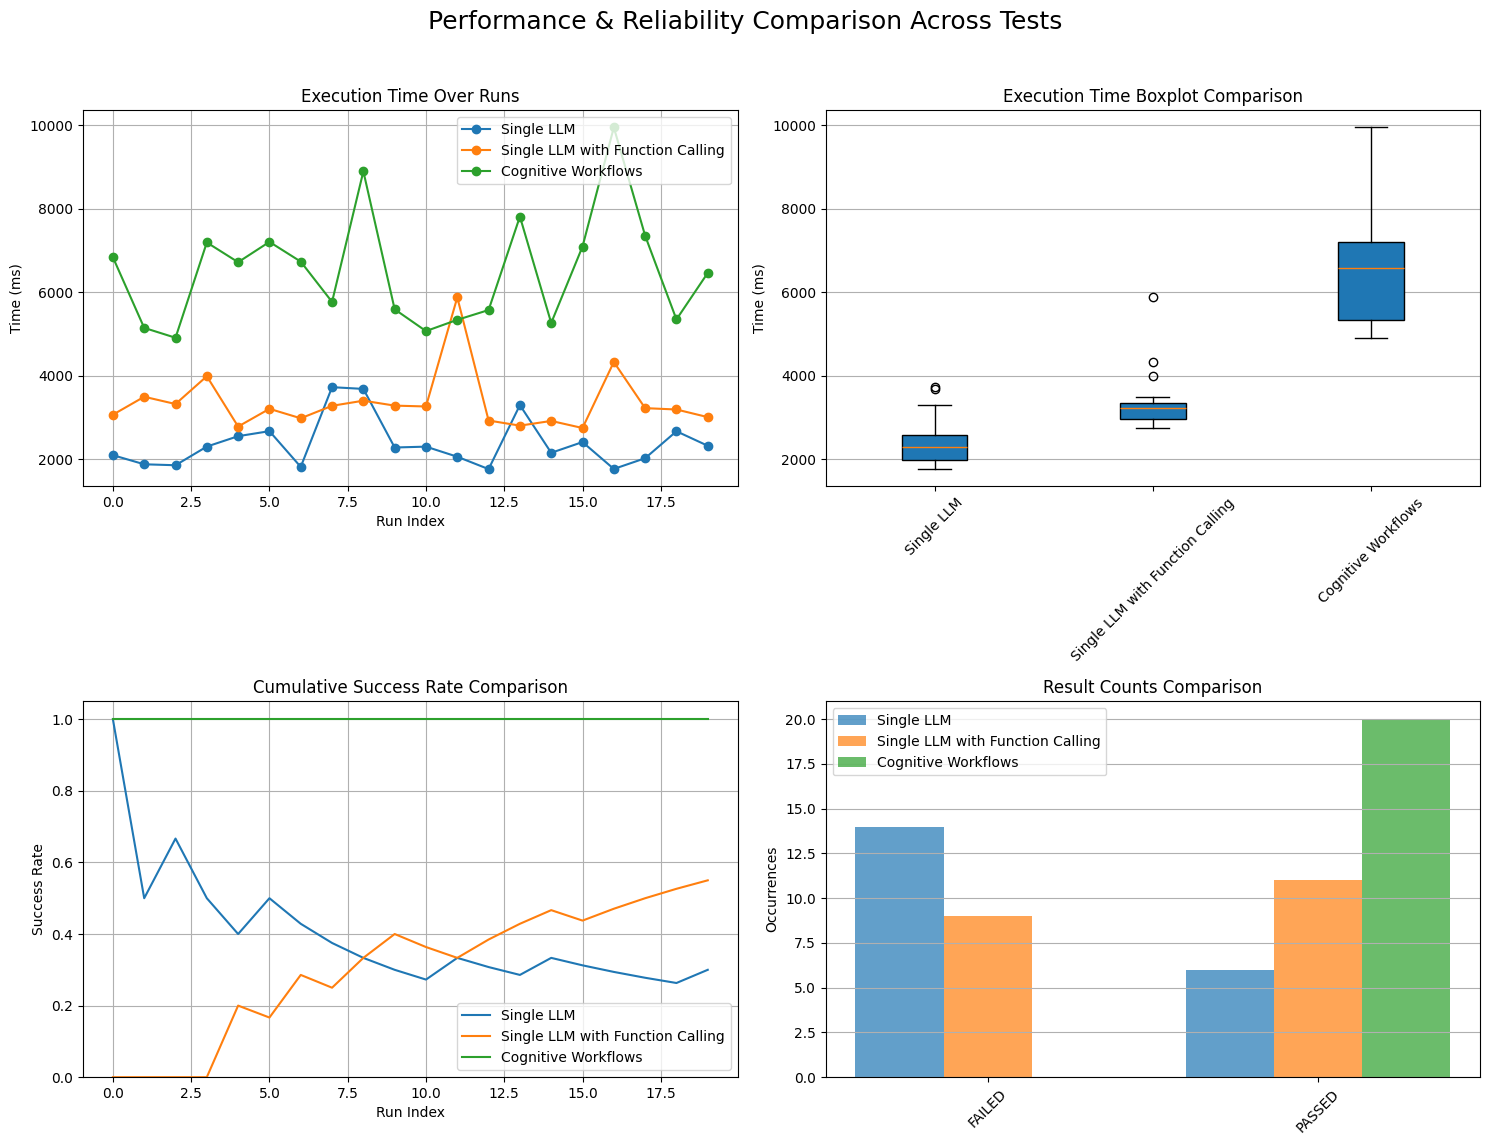

In [15]:
plot_flexible_test_comparison(
    [
        (simple_llm_results,"Single LLM"),
        (function_calling_llm_results,"Single LLM with Function Calling"),
        (cognitive_workflow_results,"Cognitive Workflows")
    ]
)

In [21]:
save_results_to_csv(simple_llm_results,
                    "res/20-I want to establish a 5G reliable connection to my friend/simple_llm.csv")
save_results_to_csv(function_calling_llm_results,
                    "res/20-I want to establish a 5G reliable connection to my friend/function_calling.csv")
save_results_to_csv(cognitive_workflow_results,
                    "res/20-I want to establish a 5G reliable connection to my friend/cognitive_workflows.csv")

Results successfully saved to simple_llm.csv
Results successfully saved to function_calling.csv
Results successfully saved to cognitive_workflows.csv
